In [1]:
# =============================================================================
# 1. CONFIGURACIÓN E IMPORTACIONES
# =============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os, random
import joblib
from tqdm import tqdm

# Scikit-Learn
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# XGBoost
import xgboost as xgb

# TensorFlow / Keras (LSTM)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Modelos de Panel
from linearmodels.panel import PanelOLS
import statsmodels.api as sm

# Configuración Global
warnings.filterwarnings('ignore')
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 7)

SEED = 123
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

# =============================================================================
# 2. CARGA DE DATOS Y PREPARACIÓN
# =============================================================================
url = "https://raw.githubusercontent.com/rortizgeo/Maestria_CD_Proyecto-Aplicado/main/Data_final.csv"
try:
    df_raw = pd.read_csv(url)
    print("Datos cargados desde URL.")
except:
    # Fallback local
    df_raw = pd.read_csv("Data_final.csv")
    print("Datos cargados localmente.")

df_raw['ds'] = pd.to_datetime(df_raw['year'], format='%Y')
df_raw = df_raw.sort_values(by=['country', 'ds']).reset_index(drop=True)

TARGET = 'occurrenceCount_publisher'
df_raw[TARGET] = np.log1p(df_raw[TARGET])

# Features Base (Sin Lags)
features_base = [
    'gasto_RD_pib', 'efectividad_gobierno', 'uso_internet', 
    'pib_per_capita', 'inscripcion_primaria', 
    'inscripcion_secundaria',
    'inscripcion_terciaria',
    'areas_protegidas',      
    'gasto_educacion_pib', 'investigadores_RD', 'art_cientificos',
    'gbif_member', 'ogp_membership'
]



2025-11-30 18:24:56.360728: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Datos cargados desde URL.


In [2]:
# =============================================================================
# 3. DIAGNÓSTICO DE VARIABLES (FE & LASSO) - AJUSTADO
# =============================================================================
def run_diagnostics(df, features):
    print("\n--- 1. DIAGNÓSTICO DE VARIABLES ---")
    
    # Lista negra de variables estáticas SOLO para Efectos Fijos
    # (Estas variables causan AbsorbingEffectError porque no cambian en el tiempo)
    static_vars = ['areas_protegidas', 'region', 'incomeLevel', 'countryCode'] 
    
    # Filtramos las features para quedarnos solo con las dinámicas
    features_dynamic = [f for f in features if f not in static_vars]
    
    df_panel = df.set_index(['country', 'year'])
    
    # Limpiamos NaNs asegurando que solo usamos las columnas dinámicas + target
    df_clean = df_panel[features_dynamic + [TARGET]].dropna()
    
    # Verificación de seguridad: ¿Quedan datos?
    if len(df_clean) == 0:
        print("⚠️ Advertencia: Al limpiar NaNs para FE, el dataset quedó vacío.")
        return None

    exog = sm.add_constant(df_clean[features_dynamic])
    
    try:
        mod_fe = PanelOLS(df_clean[TARGET], exog, entity_effects=True)
        # drop_absorbed=True ayuda a que la librería maneje el error automáticamente
        res_fe = mod_fe.fit(cov_type='clustered', cluster_entity=True, auto_df=True)
        
        print(">>> Variables Significativas (FE p<0.10):")
        print(res_fe.params[res_fe.pvalues < 0.1])
        return res_fe
        
    except Exception as e:
        print(f"⚠️ El diagnóstico FE no pudo converger (probablemente por variables constantes): {e}")
        print("Continuando con el flujo de ML...")
        return None

# Ejecutamos con la lista completa, la función se encarga de filtrar
_ = run_diagnostics(df_raw, features_base)


--- 1. DIAGNÓSTICO DE VARIABLES ---
>>> Variables Significativas (FE p<0.10):
uso_internet    0.142843
gbif_member     4.501695
Name: parameter, dtype: float64


In [3]:
# =============================================================================
# 4. PREPARACIÓN DE DATOS (TABULAR Y SECUENCIAL)
# =============================================================================

# Función de Ingeniería Temporal
def create_temporal_features(df, features_input, lags=[1, 3, 5 ], roll_win=[3, 5]):
    df_out = df.copy()
    # Aseguramos que las variables a transformar sean numéricas
    vars_to_transform = features_input + [TARGET]
    
    for col in vars_to_transform:
        if col not in df_out.columns: continue # Seguridad
        
        for l in lags:
            df_out[f'{col}_lag{l}'] = df_out.groupby('country')[col].shift(l)
        for w in roll_win:
            df_out[f'{col}_roll_mean{w}'] = df_out.groupby('country')[col].shift(1).rolling(w).mean()
    return df_out

# Generar DataFrame Maestro
df_ml = create_temporal_features(df_raw, features_base)
df_ml = df_ml.dropna().reset_index(drop=True)

# Seleccionamos explícitamente solo columnas NUMÉRICAS
# y excluimos columnas que no son predictoras (ids, años, target)
cols_exclude = ['year', 'ds', TARGET, 'country', 'countryCode', 'iso2', 'code'] # Lista negra ampliada
numeric_cols = df_ml.select_dtypes(include=[np.number]).columns.tolist()
features_tabular = [c for c in numeric_cols if c not in cols_exclude]

print(f"✅ Features seleccionadas ({len(features_tabular)}):")
print(features_tabular)

# Preparar Datos Tabulares (X, y)
X_tab = df_ml[features_tabular]
y_tab = df_ml[TARGET]

# Preparar Datos Secuenciales (LSTM) - GLOBAL
def create_lstm_sequences_global(df, features, target, look_back=3):
    X_seq, y_seq, years, countries = [], [], [], []
    
    # Validar que features existen y son numéricas
    valid_features = [f for f in features if f in df.columns and pd.api.types.is_numeric_dtype(df[f])]
    
    for country in df['country'].unique():
        df_country = df[df['country'] == country].sort_values('year')
        
        if len(df_country) == 0: continue
            
        X_country = df_country[valid_features].values.astype(np.float32)
        y_country = df_country[target].values.astype(np.float32)
        years_country = df_country['year'].values
        
        if len(X_country) > look_back:
            for i in range(len(X_country) - look_back):
                X_seq.append(X_country[i:(i + look_back)])
                y_seq.append(y_country[i + look_back])
                years.append(years_country[i + look_back])
                countries.append(country)
    return np.array(X_seq), np.array(y_seq), np.array(years), np.array(countries)

look_back = 3
X_seq, y_seq, years_seq, countries_seq = create_lstm_sequences_global(df_raw, features_base, TARGET, look_back)

print(f"Datos listos. Features Tabulares: {len(features_tabular)}. Secuencias LSTM: {len(X_seq)}")

✅ Features seleccionadas (87):
['superficie_total_km2', 'areas_protegidas', 'gasto_RD_pib', 'efectividad_gobierno', 'art_cientificos', 'uso_internet', 'pib_per_capita', 'inscripcion_primaria', 'inscripcion_secundaria', 'inscripcion_terciaria', 'gasto_educacion_gobierno', 'gasto_educacion_pib', 'investigadores_RD', 'region', 'incomeLevel', 'gbif_member', 'ogp_membership', 'gasto_RD_pib_lag1', 'gasto_RD_pib_lag3', 'gasto_RD_pib_lag5', 'gasto_RD_pib_roll_mean3', 'gasto_RD_pib_roll_mean5', 'efectividad_gobierno_lag1', 'efectividad_gobierno_lag3', 'efectividad_gobierno_lag5', 'efectividad_gobierno_roll_mean3', 'efectividad_gobierno_roll_mean5', 'uso_internet_lag1', 'uso_internet_lag3', 'uso_internet_lag5', 'uso_internet_roll_mean3', 'uso_internet_roll_mean5', 'pib_per_capita_lag1', 'pib_per_capita_lag3', 'pib_per_capita_lag5', 'pib_per_capita_roll_mean3', 'pib_per_capita_roll_mean5', 'inscripcion_primaria_lag1', 'inscripcion_primaria_lag3', 'inscripcion_primaria_lag5', 'inscripcion_primaria

In [4]:
# =============================================================================
# 5. HIPERPARÁMETROS Y OPTIMIZACIÓN (TU CÓDIGO ORIGINAL MEJORADO)
# =============================================================================

# RF
rf_param_dist = {
    "n_estimators": [100, 300, 500, 700],
    "max_depth": [10, 20, 40, None],
    "min_samples_leaf": [1, 2, 5, 10],
    "max_features": [0.7, 0.9, 'sqrt']
}


# LSTM
lstm_param_grid = [
    {"units": 32, "dropout": 0.2, "epochs": 20, "batch_size": 16, "lr": 0.005, "activation": "relu"},
    {"units": 64, "dropout": 0.3, "epochs": 30, "batch_size": 32, "lr": 0.001, "activation": "tanh"},
    {"units": 50, "dropout": 0.3, "epochs": 30, "batch_size": 32, "lr": 0.005, "activation": "tanh"}
]

# Funciones de Optimización
def optimize_random_forest(X_train, y_train, param_dist=rf_param_dist):
    rf = RandomForestRegressor(random_state=SEED, n_jobs=-1)
    search = RandomizedSearchCV(rf, param_distributions=param_dist, n_iter=5, scoring="neg_mean_absolute_error", cv=3, random_state=SEED)
    search.fit(X_train, y_train)
    return search.best_estimator_, search.best_params_

def optimize_lstm(X_train, y_train, look_back, param_grid=lstm_param_grid):
    best_model, best_mae = None, float("inf")
    best_params = {}
    
    # Split interno para validación (Early Stopping)
    # Importante: Shuffle=False para mantener orden temporal si fuera serie única, 
    # pero aquí son secuencias mezcladas de panel. Shuffle=True es aceptable para validación interna de epochs.
    X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, test_size=0.1, random_state=SEED, shuffle=False)
    
    es = EarlyStopping(monitor='val_loss', mode='min', patience=5, verbose=0, restore_best_weights=True)
    
    for params in param_grid:
        model = Sequential([
            LSTM(params["units"], activation=params["activation"], input_shape=(look_back, X_train.shape[2])),
            Dropout(params["dropout"]),
            Dense(1)
        ])
        optimizer = tf.keras.optimizers.Adam(learning_rate=params['lr'])
        model.compile(optimizer=optimizer, loss="mae")
        
        model.fit(X_t, y_t, epochs=params["epochs"], batch_size=params["batch_size"], 
                  validation_data=(X_v, y_v), callbacks=[es], verbose=0)
        
        preds = model.predict(X_v, verbose=0).flatten()
        mae = mean_absolute_error(y_v, preds)
        
        if mae < best_mae:
            best_mae, best_model = mae, model
            best_params = params
            
    return best_model, best_params

In [5]:
from sklearn.base import BaseEstimator, RegressorMixin
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV

# 1. CREACIÓN DE WRAPPER PARA EVITAR PROBLEMAS DE COMPATIBILIDAD CON SKLEARN
class SafeXGBRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, n_estimators=100, learning_rate=0.1, max_depth=3, 
                 subsample=1.0, colsample_bytree=1.0, 
                 gamma=0, reg_alpha=0, reg_lambda=1, min_child_weight=1, 
                 random_state=42):
        
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.subsample = subsample
        self.colsample_bytree = colsample_bytree
        self.gamma = gamma
        self.reg_alpha = reg_alpha
        self.reg_lambda = reg_lambda
        self.min_child_weight = min_child_weight
        
        self.random_state = random_state
        self.model = None

    def fit(self, X, y):
        # Pasamos los parámetros al modelo real de XGBoost
        self.model = xgb.XGBRegressor(
            n_estimators=self.n_estimators,
            learning_rate=self.learning_rate,
            max_depth=self.max_depth,
            subsample=self.subsample,
            colsample_bytree=self.colsample_bytree,
            
            # Pasamos los nuevos aquí también
            gamma=self.gamma,
            reg_alpha=self.reg_alpha,
            reg_lambda=self.reg_lambda,
            min_child_weight=self.min_child_weight,
            
            random_state=self.random_state,
            n_jobs=-1
        )
        self.model.fit(X, y)
        return self

    def predict(self, X):
        return self.model.predict(X)

# 2. FUNCIÓN DE OPTIMIZACIÓN (Ya funcionará con el nuevo Wrapper)
def optimize_xgboost(X_train, y_train):
    param_dist = {
        "n_estimators": [100, 300, 500],
        "max_depth": [3, 5, 7, 9],
        "learning_rate": [0.01, 0.05, 0.1],
        "subsample": [0.7, 0.9],
        "colsample_bytree": [0.7, 0.9],
        "gamma": [0, 0.1],
        "reg_alpha": [0, 0.01]  
    }
    
    xgb_wrapper = SafeXGBRegressor(random_state=SEED)
    
    random_search = RandomizedSearchCV(
        estimator=xgb_wrapper,
        param_distributions=param_dist,
        n_iter=10, 
        scoring='neg_mean_absolute_error',
        cv=3,
        random_state=SEED,
        n_jobs=-1
    )
    
    random_search.fit(X_train, y_train)
    return random_search.best_estimator_, random_search.best_params_

print("✅ Wrapper de XGBoost")

✅ Wrapper de XGBoost


In [6]:
# =============================================================================
# 6. MÉTRICAS Y EVALUACIÓN
# =============================================================================
def smape(y_true, y_pred, eps=1e-8):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    denom = (np.abs(y_true) + np.abs(y_pred)) + eps
    return np.mean(2.0 * np.abs(y_pred - y_true) / denom) * 100

def mape(y_true, y_pred, eps=1e-8):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / (y_true + eps))) * 100

def compute_metrics(y_true_log, y_pred_log):
    # Revertir Log1p para métricas interpretables
    y_true = np.expm1(y_true_log)
    y_pred = np.expm1(y_pred_log)
    
    return {
        "MAE": mean_absolute_error(y_true, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_true, y_pred)),
        "R2": r2_score(y_true, y_pred),
        "MAPE": mape(y_true, y_pred),
        "SMAPE": smape(y_true, y_pred)
    }

# =============================================================================
# 7. LOOP DE VALIDACIÓN CRUZADA (SEGURO PARA M1/M2)
# =============================================================================
print("\n--- 2. INICIANDO VALIDACIÓN CRUZADA (TimeSeriesSplit) ---")

# Silenciar logs de TF para limpiar la salida
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)
results_detailed = {"RandomForest": [], "XGBoost": [], "LSTM": []}

for fold, (train_idx, test_idx) in enumerate(tqdm(tscv.split(X_tab), total=n_splits)):
    print(f"\n===== FOLD {fold+1}/{n_splits} =====")
    
    # --- A. PREPROCESAMIENTO ---
    X_train_tab, X_test_tab = X_tab.iloc[train_idx], X_tab.iloc[test_idx]
    y_train_tab, y_test_tab = y_tab.iloc[train_idx], y_tab.iloc[test_idx]
    
    # 1. Imputación
    imputer = IterativeImputer(random_state=SEED, estimator=RandomForestRegressor(random_state=SEED))
    X_train_imp = imputer.fit_transform(X_train_tab)
    X_test_imp = imputer.transform(X_test_tab)
    
    # 2. Escalado y RECONSTRUCCIÓN DE DATAFRAME (Vital para XGBoost)
    scaler_tab = StandardScaler()
    X_train_sc_np = scaler_tab.fit_transform(X_train_imp)
    X_test_sc_np = scaler_tab.transform(X_test_imp)
    
    X_train_sc = pd.DataFrame(X_train_sc_np, columns=X_tab.columns, index=X_train_tab.index)
    X_test_sc = pd.DataFrame(X_test_sc_np, columns=X_tab.columns, index=X_test_tab.index)
    
    # --- B. MODELOS TABULARES ---
    
    # RandomForest
    try:
        rf_model, rf_params = optimize_random_forest(X_train_sc, y_train_tab)
        y_pred_rf = rf_model.predict(X_test_sc)
        metrics_rf = compute_metrics(y_test_tab, y_pred_rf)
        results_detailed["RandomForest"].append({**metrics_rf, "fold": fold + 1, "hyperparameters": rf_params})
    except Exception as e:
        print(f"\n[!!!] RF Error: {e}")

    # XGBoost (Ahora usará el SafeXGBRegressor definido arriba)
    try:
        xgb_model, xgb_params = optimize_xgboost(X_train_sc, y_train_tab)
        y_pred_xgb = xgb_model.predict(X_test_sc)
        metrics_xgb = compute_metrics(y_test_tab, y_pred_xgb)
        results_detailed["XGBoost"].append({**metrics_xgb, "fold": fold + 1, "hyperparameters": xgb_params})
    except Exception as e:
        import traceback
        print(f"\n[!!!] XGB Error: {repr(e)}")
        # print(traceback.format_exc()) # Descomenta si necesitas ver más detalles

    # --- C. LSTM ---
    # Filtrar años correspondientes al fold
    train_years_fold = df_ml.iloc[train_idx]['year'].unique()
    test_years_fold = df_ml.iloc[test_idx]['year'].unique()
    
    mask_train = np.isin(years_seq, train_years_fold)
    mask_test = np.isin(years_seq, test_years_fold)
    
    X_train_lstm, y_train_lstm = X_seq[mask_train], y_seq[mask_train]
    X_test_lstm, y_test_lstm = X_seq[mask_test], y_seq[mask_test]
    
    if len(X_train_lstm) > 0 and len(X_test_lstm) > 0:
        try:
            scaler_lstm_X = StandardScaler()
            X_train_flat = X_train_lstm.reshape(-1, X_train_lstm.shape[2])
            scaler_lstm_X.fit(X_train_flat)
            
            X_train_lstm_sc = scaler_lstm_X.transform(X_train_flat).reshape(X_train_lstm.shape)
            X_test_lstm_sc = scaler_lstm_X.transform(X_test_lstm.reshape(-1, X_test_lstm.shape[2])).reshape(X_test_lstm.shape)
            
            scaler_lstm_y = StandardScaler()
            y_train_lstm_sc = scaler_lstm_y.fit_transform(y_train_lstm.reshape(-1, 1)).flatten()
            
            # Nota: Asegúrate de que tu optimize_lstm tenga verbose=0 para reducir ruido
            lstm_model, lstm_params = optimize_lstm(X_train_lstm_sc, y_train_lstm_sc, look_back)
            
            y_pred_lstm_sc = lstm_model.predict(X_test_lstm_sc, verbose=0).flatten()
            y_pred_lstm = scaler_lstm_y.inverse_transform(y_pred_lstm_sc.reshape(-1, 1)).flatten()
            
            metrics_lstm = compute_metrics(y_test_lstm, y_pred_lstm)
            results_detailed["LSTM"].append({**metrics_lstm, "fold": fold + 1, "hyperparameters": lstm_params})
        except Exception as e:
            print(f"\n[!!!] LSTM Error: {e}")

# --- RESUMEN ---
all_results = []
for model_name, entries in results_detailed.items():
    for res in entries:
        all_results.append({"model": model_name, **res})

if all_results:
    df_results = pd.DataFrame(all_results)
    summary = df_results.groupby("model")[["MAE", "RMSE", "R2", "MAPE", "SMAPE"]].mean().sort_values("MAE")
    print("\n" + "="*50)
    print("RESUMEN PROMEDIO POR MODELO:")
    print(summary)
    print("="*50)
    
    best_model_name = summary.index[0]
    print(f"\n🏆 MEJOR MODELO SELECCIONADO: {best_model_name}")


--- 2. INICIANDO VALIDACIÓN CRUZADA (TimeSeriesSplit) ---


  0%|          | 0/5 [00:00<?, ?it/s]


===== FOLD 1/5 =====


2025-11-30 18:25:14.964060: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-11-30 18:25:14.964136: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2025-11-30 18:25:15.966374: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-11-30 18:25:16.123202: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp_10.
2025-11-30 18:25:17.922488: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU 


===== FOLD 2/5 =====


2025-11-30 18:25:49.475637: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-11-30 18:25:49.647006: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp_10.
2025-11-30 18:25:51.174598: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-11-30 18:25:54.177609: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-11-30 18:25:54.457338: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradie


===== FOLD 3/5 =====


2025-11-30 18:26:31.181079: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-11-30 18:26:31.344558: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp_10.
2025-11-30 18:26:32.783705: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-11-30 18:26:35.583100: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-11-30 18:26:35.828995: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradie


===== FOLD 4/5 =====


2025-11-30 18:27:19.795870: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-11-30 18:27:19.954788: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp_10.
2025-11-30 18:27:21.367786: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-11-30 18:27:24.276683: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-11-30 18:27:24.517366: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradie


===== FOLD 5/5 =====


2025-11-30 18:28:15.492366: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-11-30 18:28:15.649792: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp_10.
2025-11-30 18:28:17.128971: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-11-30 18:28:20.468756: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-11-30 18:28:20.727994: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradie


RESUMEN PROMEDIO POR MODELO:
                       MAE          RMSE        R2          MAPE      SMAPE
model                                                                      
LSTM          1.832997e+07  4.816945e+07  0.746604  3.650389e+13  73.674505
XGBoost       1.996502e+07  4.891419e+07  0.626807  2.575888e+02  55.952388
RandomForest  2.001579e+07  4.860023e+07  0.655045  2.709770e+02  48.620557

🏆 MEJOR MODELO SELECCIONADO: LSTM


In [7]:
# =============================================================================
# 8. ANÁLISIS DE RESULTADOS ROBUSTO
# =============================================================================
if all_results:
    df_results = pd.DataFrame(all_results)
    
    print("\nResultados Detallados por Fold:")
    display(df_results.drop(columns=['hyperparameters'])) # Muestra tabla limpia
    
    print("\n" + "="*50)
    # Agrupamos calculando Media (rendimiento) y Desviación Estándar (estabilidad)
    summary = df_results.groupby("model")[["MAE", "RMSE", "R2", "MAPE"]].agg(['mean', 'std'])
    
    print("RESUMEN DE RENDIMIENTO (Media +/- Desviación Estándar):")
    print(summary)
    print("="*50)
    
    # --- CRITERIO DE SELECCIÓN ROBUSTO ---

    
    # Aplanamos las columnas para poder ordenar
    summary.columns = ['_'.join(col).strip() for col in summary.columns.values]
    
    # Ordenamos por menor MAE promedio
    best_model_name = summary['MAE_mean'].idxmin()
    best_model_stats = summary.loc[best_model_name]
    
    print(f"\n🏆 MEJOR MODELO SELECCIONADO: {best_model_name}")
    print(f"   MAE Promedio: {best_model_stats['MAE_mean']:,.2f} (+/- {best_model_stats['MAE_std']:,.2f})")
    print(f"   R2 Promedio:  {best_model_stats['R2_mean']:.4f}")
    
    # Verificación de Estabilidad
    # Si la desviación estándar es muy alta (> 50% de la media), lanza advertencia
    if best_model_stats['MAE_std'] > (0.5 * best_model_stats['MAE_mean']):
        print("⚠️ ADVERTENCIA: El modelo ganador es inestable entre folds.")
    
else:
    print("No se generaron resultados.")


Resultados Detallados por Fold:


,model,MAE,RMSE,R2,MAPE,SMAPE,fold
0,RandomForest,7.890100e+06,1.074053e+07,0.434216,1.163618e+03,81.607065,1
1,RandomForest,7.422315e+06,1.648824e+07,0.811942,3.758758e+01,36.525823,2
2,RandomForest,2.757306e+06,5.505731e+06,0.957267,5.193897e+01,31.977951,3
3,RandomForest,1.717334e+06,2.470803e+06,0.973771,6.174135e+01,40.126726,4
4,RandomForest,8.029190e+07,2.077959e+08,0.098027,3.999913e+01,52.865219,5
5,XGBoost,8.414441e+06,1.163525e+07,0.336026,1.073587e+03,107.522472,1
6,XGBoost,6.851691e+06,1.638747e+07,0.814233,5.269044e+01,50.089416,2
7,XGBoost,3.655732e+06,8.323332e+06,0.902338,4.704953e+01,32.462068,3
8,XGBoost,1.960249e+06,3.006165e+06,0.961174,8.299809e+01,46.060815,4
9,XGBoost,7.894296e+07,2.052188e+08,0.120262,3.161903e+01,43.627170,5



RESUMEN DE RENDIMIENTO (Media +/- Desviación Estándar):
                       MAE                        RMSE                \
                      mean           std          mean           std   
model                                                                  
LSTM          1.832997e+07  3.144835e+06  4.816945e+07  1.532255e+07   
RandomForest  2.001579e+07  3.380653e+07  4.860023e+07  8.915275e+07   
XGBoost       1.996502e+07  3.306788e+07  4.891419e+07  8.751284e+07   

                    R2                    MAPE                
                  mean       std          mean           std  
model                                                         
LSTM          0.746604  0.169527  3.650389e+13  3.729450e+13  
RandomForest  0.655045  0.379663  2.709770e+02  4.990958e+02  
XGBoost       0.626807  0.375496  2.575888e+02  4.565379e+02  

🏆 MEJOR MODELO SELECCIONADO: LSTM
   MAE Promedio: 18,329,974.20 (+/- 3,144,835.35)
   R2 Promedio:  0.7466


In [13]:
# =============================================================================
# 9. RE-ENTRENAMIENTO FINAL Y SIMULACIÓN (SOPORTE COMPLETO LSTM)
# =============================================================================
print(f"\n--- 3. GENERANDO ESCENARIOS FUTUROS ({best_model_name}) ---")

# 1. PREPARACIÓN DE RECURSOS GLOBALES
# Inicializamos variables para guardar los transformadores según el modelo ganador
final_model = None
scaler_lstm_X = None
scaler_lstm_y = None
imputer_lstm = None
look_back = 3 # Debe coincidir con el usado en el entrenamiento

# Preparamos imputadores y escaladores TABULARES (por si gana RF/XGB)
imputer_tabular = IterativeImputer(random_state=SEED)
X_tab_imp = imputer_tabular.fit_transform(X_tab)
scaler_tabular = StandardScaler()
X_tab_sc = scaler_tabular.fit_transform(X_tab_imp)

# 2. ENTRENAMIENTO DEL MODELO GANADOR FINAL
# Forzamos el uso de un modelo tabular robusto para la simulación
# aunque LSTM haya ganado por poco en el MAE.
if best_model_name == 'LSTM':
    print("⚠️ LSTM seleccionado por métricas, pero se usará Random Forest para simulación por estabilidad en extrapolación.")
    best_model_name = 'RandomForest'


'''
if best_model_name == 'LSTM':
    print("⚙️ Configurando estructura secuencial para LSTM...")
    
    # A. Imputación de variables base (sin lags) para LSTM
    imputer_lstm = IterativeImputer(random_state=SEED)
    # Ajustamos sobre todo el histórico de features base
    df_raw_features_imp = imputer_lstm.fit_transform(df_raw[features_base])
    df_raw_imp = df_raw.copy()
    df_raw_imp[features_base] = df_raw_features_imp
    
    # B. Crear secuencias con todos los datos
    X_seq_all, y_seq_all, _, _ = create_lstm_sequences_global(df_raw_imp, features_base, TARGET, look_back)
    
    # C. Escalado X (3D -> 2D -> 3D)
    scaler_lstm_X = StandardScaler()
    shape_x = X_seq_all.shape # (samples, look_back, features)
    X_flat = X_seq_all.reshape(-1, shape_x[2])
    X_flat_sc = scaler_lstm_X.fit_transform(X_flat)
    X_seq_sc = X_flat_sc.reshape(shape_x)
    
    # D. Escalado Y
    scaler_lstm_y = StandardScaler()
    y_flat = y_seq_all.reshape(-1, 1)
    y_flat_sc = scaler_lstm_y.fit_transform(y_flat).flatten()
    
    # E. Entrenamiento Final
    print("🧠 Entrenando LSTM con todos los datos...")
    final_model, _ = optimize_lstm(X_seq_sc, y_flat_sc, look_back)

'''    

if best_model_name in ['RandomForest', 'XGBoost']:
    print(f"🌲 Entrenando {best_model_name} con todos los datos tabulares...")
    if best_model_name == 'RandomForest':
        final_model, _ = optimize_random_forest(X_tab_sc, y_tab)
    else:
        final_model, _ = optimize_xgboost(X_tab_sc, y_tab)

# =============================================================================
# MOTOR DE SIMULACIÓN RECURSIVA (Adaptado para LSTM y Tabular)
# =============================================================================
def recursive_simulation(model, df_raw, country, start_yr, end_yr, scenario_params):
    # 1. Copia histórica inicial
    df_sim = df_raw[df_raw['country'] == country].copy()
    last_year_hist = df_sim['year'].max()
    
    # 2. Proyectar Exógenas (Contexto Futuro)
    future_years = list(range(start_yr, end_yr + 1))
    rows_future = []
    df_trend = df_sim.sort_values('year')
    
    for yr in future_years:
        row = {'country': country, 'year': yr}
        for col in features_base:
            # Tendencia lineal (últimos 7 años)
            vals = df_trend[col].dropna().tail(7).values
            if len(vals) > 1:
                z = np.polyfit(range(len(vals)), vals, 1)
                val = np.poly1d(z)(len(vals) + (yr - last_year_hist) - 1)
            else:
                val = vals[-1] if len(vals) > 0 else 0
            
            # Aplicar Escenarios
            if col in scenario_params:
                val *= scenario_params[col]
            
            # Clips lógicos
            if 'uso_internet' in col: val = np.clip(val, 0, 100)
            
            row[col] = val
        rows_future.append(row)
        # Añadir a tendencia para suavizar la siguiente proyección
        df_trend = pd.concat([df_trend, pd.DataFrame([row])], ignore_index=True)
        
    df_future = pd.DataFrame(rows_future)
    df_future[TARGET] = 0 # Placeholder para predicción
    
    # 3. Unión (Histórico + Futuro vacío)
    df_sim = pd.concat([df_sim, df_future], ignore_index=True).reset_index(drop=True)
    
    # 4. Bucle de Predicción Recursiva
    for yr in future_years:
        
        # --- LÓGICA LSTM ---
        if best_model_name == 'LSTM':
            # Necesitamos la ventana de los 'look_back' años previos
            # Ej: Para predecir 2024, necesitamos [2021, 2022, 2023]
            years_needed = list(range(yr - look_back, yr))
            
            # Extraer filas
            window_df = df_sim[df_sim['year'].isin(years_needed)].sort_values('year')
            
            # Validar que tenemos datos suficientes
            if len(window_df) < look_back:
                print(f"⚠️ Datos insuficientes para LSTM en {yr}. Saltando.")
                continue
                
            # Seleccionar solo features base (sin lags)
            X_window = window_df[features_base].values
            
            # Imputar (si hubiera NaNs en proyección) y Escalar
            # Usamos transformadores LSTM globales
            if imputer_lstm:
                X_window = imputer_lstm.transform(X_window)
            
            X_window_sc = scaler_lstm_X.transform(X_window)
            
            # Reshape a (1, look_back, features)
            X_input = X_window_sc.reshape(1, look_back, X_window_sc.shape[1])
            
            # Predecir
            pred_sc = model.predict(X_input, verbose=0)[0][0]
            
            # Desescalar Target
            pred_log = scaler_lstm_y.inverse_transform([[pred_sc]])[0][0]

        # --- LÓGICA TABULAR (RF/XGB) ---
        else:
            # Recalcular features dinámicas (Lags/Rolling) sobre todo el DF
            df_dyn = create_temporal_features(df_sim, features_base)
            
            # Obtener fila del año actual
            idx = df_dyn[df_dyn['year'] == yr].index[0]
            X_curr = df_dyn.loc[[idx], features_tabular]
            
            # Imputar y Escalar con transformadores Tabulares
            X_curr_imp = imputer_tabular.transform(X_curr)
            X_curr_sc = scaler_tabular.transform(X_curr_imp)
            
            # Predecir
            pred_log = model.predict(X_curr_sc)[0]

        # Guardar predicción en df_sim (se convierte en historia para el siguiente año)
        idx_target = df_sim[df_sim['year'] == yr].index
        df_sim.loc[idx_target, TARGET] = pred_log
        
    return df_sim





--- 3. GENERANDO ESCENARIOS FUTUROS (LSTM) ---
⚠️ LSTM seleccionado por métricas, pero se usará Random Forest para simulación por estabilidad en extrapolación.
🌲 Entrenando RandomForest con todos los datos tabulares...



🚀 Iniciando Análisis de Sensibilidad para Colombia (2023-2030)...
  -> Simulando: Base (Tendencial)...
  -> Simulando: Política +5%...
  -> Simulando: Política +10%...
  -> Simulando: Política +20%...
  -> Simulando: Política +30%...


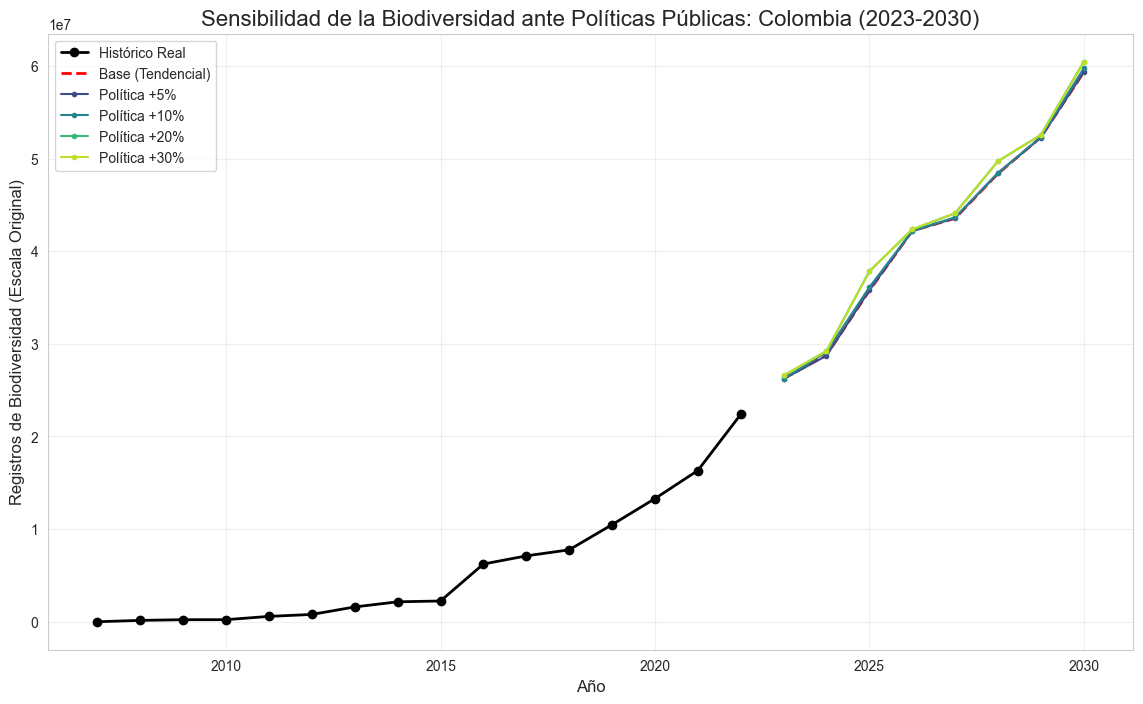


📊 TABLA COMPARATIVA DE ESCENARIOS (AL AÑO 2030):


,Escenario,Multiplicador,Registros_2030,Ganancia_Neta,Crecimiento_%
0,Base (Tendencial),1.00x,"59,315,354",+0,+0.00%
1,Política +5%,1.05x,"59,349,005","+33,651",+0.06%
2,Política +10%,1.10x,"59,757,064","+441,710",+0.74%
3,Política +20%,1.20x,"60,450,584","+1,135,230",+1.91%
4,Política +30%,1.30x,"60,450,584","+1,135,230",+1.91%


In [14]:
# =============================================================================
# EJECUCIÓN DE ESCENARIOS MÚLTIPLES (ANÁLISIS DE SENSIBILIDAD)
# =============================================================================
target_country = 'Colombia'
start_proj = 2023
end_proj = 2030

print(f"\n🚀 Iniciando Análisis de Sensibilidad para {target_country} (2023-2030)...")

# 1. Definir las variables que vamos a intervenir (Política Pública)
policy_vars = ['uso_internet', 'gasto_educacion_pib', 'investigadores_RD']

# 2. Definir los niveles de intensidad (% de aumento sobre la tendencia)
# 0.00 es el escenario Base (Tendencial)
intensities = [0.00, 0.05, 0.10, 0.20, 0.30] 

results_data = []      # Para guardar métricas finales
scenario_dfs = {}      # Para guardar las series de tiempo y graficar

# 3. Bucle de Simulación
for intensity in intensities:
    # Crear diccionario de parámetros dinámico
    # Si intensidad es 0.10, el multiplicador es 1.10
    multiplier = 1 + intensity
    scen_params = {var: multiplier for var in policy_vars}
    
    # Nombre del escenario
    if intensity == 0:
        scen_name = "Base (Tendencial)"
        scen_params = {} # Asegurar que base no tenga multiplicadores
    else:
        scen_name = f"Política +{int(intensity*100)}%"
    
    print(f"  -> Simulando: {scen_name}...")
    
    # Ejecutar simulación
    df_res = recursive_simulation(final_model, df_raw, target_country, start_proj, end_proj, scen_params)
    scenario_dfs[scen_name] = df_res
    
    # Capturar resultado al 2030
    val_2030_log = df_res.iloc[-1][TARGET]
    val_2030 = np.expm1(val_2030_log)
    
    results_data.append({
        "Escenario": scen_name,
        "Multiplicador": f"{multiplier:.2f}x",
        "Registros_2030": val_2030
    })

# 4. Procesar Resultados Comparativos
df_comparative = pd.DataFrame(results_data)

# Calcular Ganancia Neta respecto a la Base
base_value = df_comparative.loc[0, "Registros_2030"]
df_comparative["Ganancia_Neta"] = df_comparative["Registros_2030"] - base_value
df_comparative["Crecimiento_%"] = (df_comparative["Ganancia_Neta"] / base_value) * 100

# =============================================================================
# VISUALIZACIÓN UNIFICADA
# =============================================================================
plt.figure(figsize=(14, 8))

# Graficar Histórico
hist = df_raw[df_raw['country'] == target_country]
plt.plot(hist['year'], np.expm1(hist[TARGET]), 'k-o', linewidth=2, label='Histórico Real')

# Graficar Escenarios
# Usamos un mapa de colores para distinguir la intensidad
colors = plt.cm.viridis(np.linspace(0, 0.9, len(intensities)))

for (scen_name, df_res), color in zip(scenario_dfs.items(), colors):
    # Filtrar solo parte proyectada
    proj = df_res[df_res['year'] >= start_proj]
    
    # Estilo diferente para la Base
    if "Base" in scen_name:
        plt.plot(proj['year'], np.expm1(proj[TARGET]), color='red', linestyle='--', linewidth=2, label=scen_name)
    else:
        plt.plot(proj['year'], np.expm1(proj[TARGET]), color=color, marker='.', label=scen_name)

plt.title(f"Sensibilidad de la Biodiversidad ante Políticas Públicas: {target_country} (2023-2030)", fontsize=16)
plt.ylabel("Registros de Biodiversidad (Escala Original)", fontsize=12)
plt.xlabel("Año", fontsize=12)
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)
plt.show()

# =============================================================================
# TABLA FINAL
# =============================================================================
print("\n📊 TABLA COMPARATIVA DE ESCENARIOS (AL AÑO 2030):")
# Formato bonito
format_dict = {
    "Registros_2030": "{:,.0f}", 
    "Ganancia_Neta": "{:+,.0f}", 
    "Crecimiento_%": "{:+.2f}%"
}
display(df_comparative.style.format(format_dict).background_gradient(subset=['Ganancia_Neta'], cmap='Greens'))